# Plot 3C waveforms of a subarray in a time window

In [45]:
## Import modules
from obspy import read, UTCDateTime, Stream
from matplotlib.pyplot import figure, subplots
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from numpy import abs, mean, amin, amax
from pandas import read_csv, Timestamp, Timedelta
from os.path import join

from utils_basic import ROOTDIR, INNER_STATIONS, days_to_timestamps
from utils_preproc import preprocess_stream
from utils_sta_lta import read_associated_events

In [46]:
## Inputs
root = "/Volumes/OmanData/geophones_no_prefilt/data"
subarray = "B"
starttime = Timestamp("2020-01-13T13:02:00")
dur = 120.0 # Duration in seconds
plot_detect = True # Plot STA/LTA detections or not
plot_assoc = True # Plot associated detections or not
sta_lta_dir = "detections_sta0.01s_lta0.20s_on5_off2"
assoc_dir = "associated_events_num8_delta0.200s"

freqmin = 10.0
freqmax = 450

scale = 5e-4 # Scale factor for plotting
size = 20 # Size of the dots for detections

In [47]:
## Read the station list
inpath = join(root, "stations.csv")
stadf = read_csv(inpath, index_col=0)
stadf = stadf.loc[stadf["subarray"] == subarray]
numst = len(stadf)

In [48]:
## Read the raw detections
stalta_dict = {}    
if plot_detect:
    for station in stadf["name"]:
        inpath = join(ROOTDIR, sta_lta_dir, f"{station}.csv")
        try:
            detdf = read_csv(inpath, index_col=0, parse_dates=["trigger_time", "detrigger_time"])
            stalta_dict[station] = detdf
        except:
            print(f"No detections for {station}")

No detections for B05


In [49]:
## Read the associated detections
if plot_assoc:
    if subarray == "A":
        inpath = join(ROOTDIR, sta_lta_dir, assoc_dir, "events_a.dat")
    elif subarray == "B":
        inpath = join(ROOTDIR, sta_lta_dir, assoc_dir, "events_b.dat")
    else:
        raise ValueError("Subarray not recognized")
    
    events = read_associated_events(inpath)

    ## Get the events in the time window
    events = events.get_events_in_interval(starttime, starttime+Timedelta(seconds=dur))

In [50]:
## Read and preprocess the data
starttime = UTCDateTime(starttime)
timewin = starttime.strftime("%Y-%m-%d-%H-00-00")
stream = Stream()
for station in stadf["name"]:
    try:
        pattern = join(root, timewin, f"*{station}*.SAC")
        stream += read(pattern)
    except:
        print(f"Could not read Station {station}")
        continue

stream = preprocess_stream(stream, freqmin, freqmax)
stream.trim(starttime, starttime + dur)

Could not read Station B05


57 Trace(s) in Stream:

7F.B01..GH1 | 2020-01-13T13:02:00.000007Z - 2020-01-13T13:04:00.000015Z | 1000.0 Hz, 120001 samples
...
(55 other traces)
...
7F.B20..GHZ | 2020-01-13T13:02:00.000007Z - 2020-01-13T13:04:00.000015Z | 1000.0 Hz, 120001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

Could not plot B05


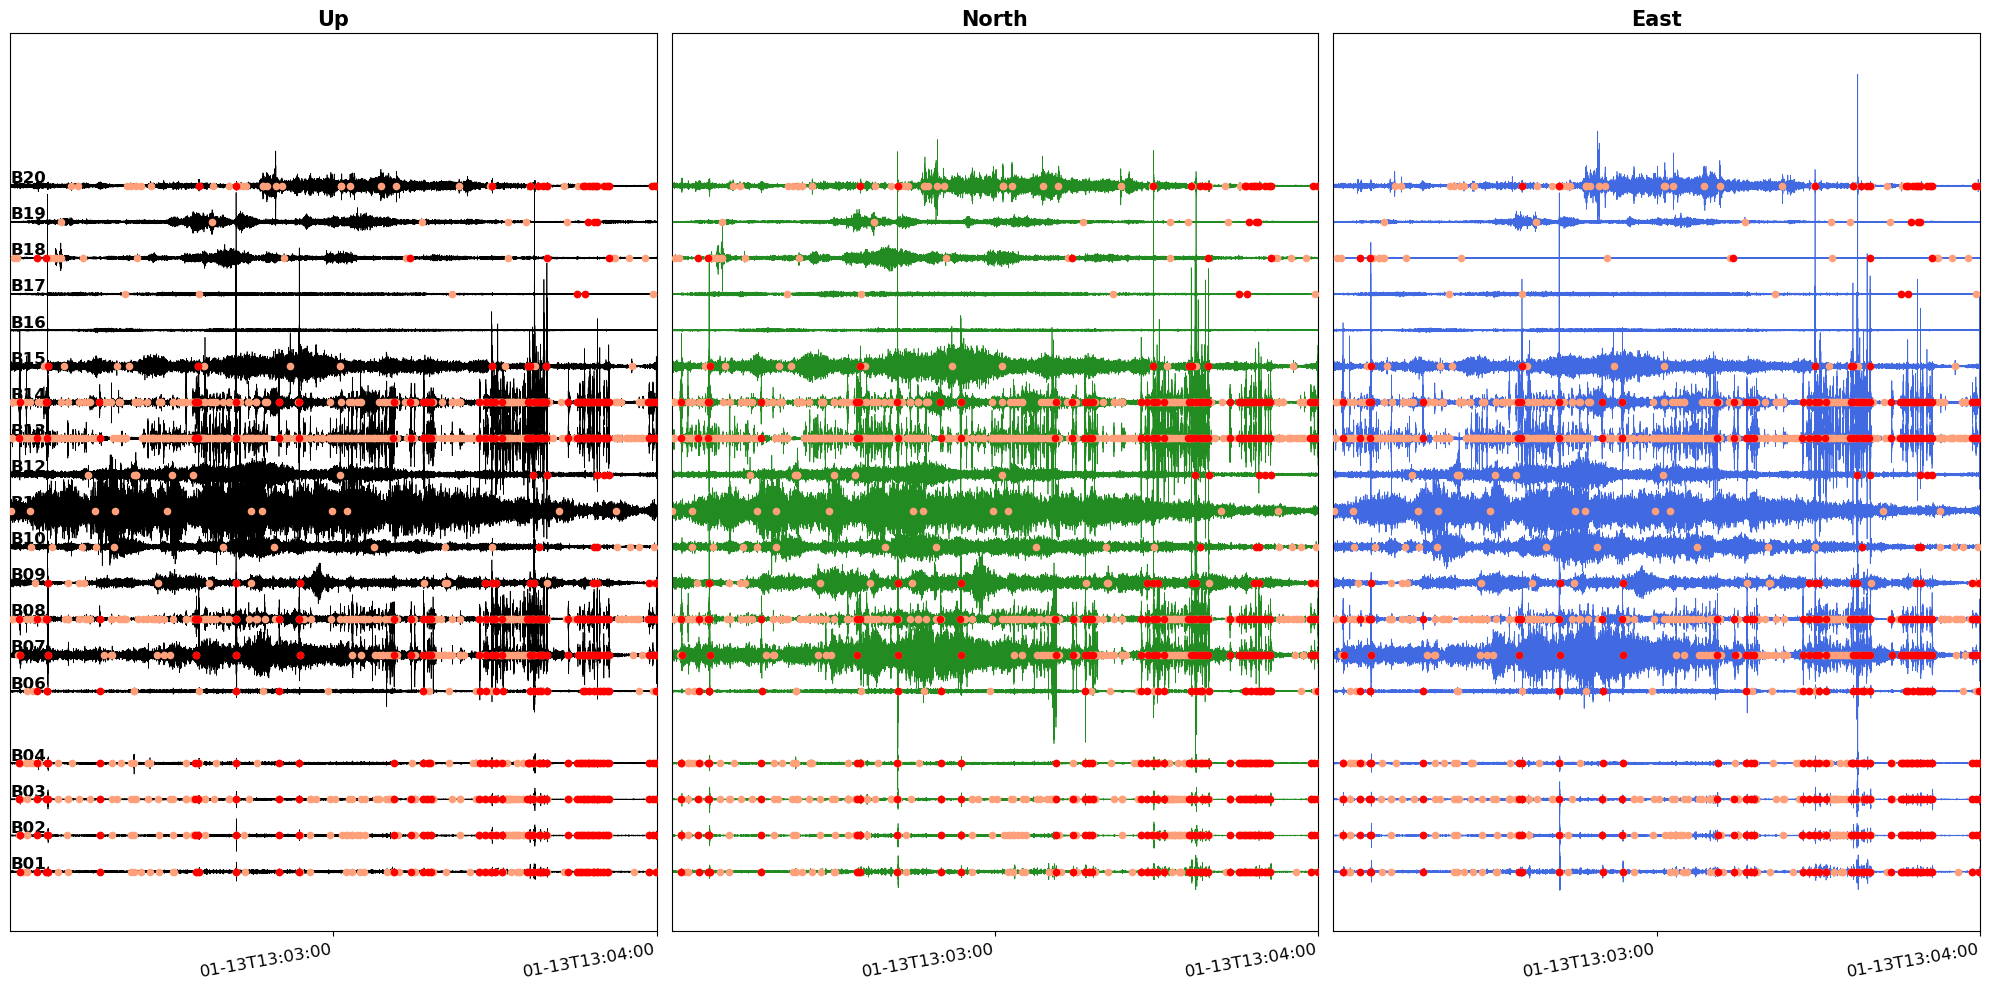

In [51]:
## Plotting
fig, axes = subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(20, 0.5*numst))

### Loop over the stations
for i, station in enumerate(stadf["name"]):

    #### Exract and plot the waveforms
    try:
        trace_z = stream.select(station=station, channel="*Z")[0]
        trace_1 = stream.select(station=station, channel="*1")[0]
        trace_2 = stream.select(station=station, channel="*2")[0]

        data_z = trace_z.data * scale + i
        data_1 = trace_1.data * scale + i
        data_2 = trace_2.data * scale + i
    except:
        print(f"Could not plot {station}")
        continue
    
    #### Convert the time axis to Pandas Timestamps
    timeax = trace_z.times("matplotlib")
    timeax = days_to_timestamps(timeax)

    axes[0].plot(timeax, data_z, color="black", linewidth=0.5)
    axes[1].plot(timeax, data_1, color="forestgreen", linewidth=0.5)
    axes[2].plot(timeax, data_2, color="royalblue", linewidth=0.5)

    axes[0].annotate(station, xy=(timeax[0], i+0.1), xycoords="data", fontsize=12, fontweight="bold")

    #### Extract and plot the raw detections
    if plot_detect:
        try:
            detdf = stalta_dict[station]
            detdf = detdf.loc[(detdf["trigger_time"] >= timeax[0]) & (detdf["trigger_time"] <= timeax[-1])]
        except:
            print(f"No detections for {station}")
            continue

        axes[0].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)
        axes[1].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)
        axes[2].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)

    axes[0].set_xlim([timeax[0], timeax[-1]])
    axes[1].set_xlim([timeax[0], timeax[-1]])
    axes[2].set_xlim([timeax[0], timeax[-1]])

    #### Extract and plot the associated detections
    if plot_assoc:
        for event in events:
            try:
                trigger, detrigger = event.get_triggers_by_station(station)
            except:
                continue
            
            axes[0].scatter(trigger, i, color="red", zorder=11, s=size)
            axes[1].scatter(trigger, i, color="red", zorder=11, s=size)
            axes[2].scatter(trigger, i, color="red", zorder=11, s=size)

## Set the x-axis limits
axes[0].set_xlim([timeax[0], timeax[-1]])
axes[1].set_xlim([timeax[0], timeax[-1]])
axes[2].set_xlim([timeax[0], timeax[-1]])

## Format x-axis as date time
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M:%S'))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M:%S'))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M:%S'))

for label in axes[0].get_xticklabels():
    label.set_fontsize(12)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

for label in axes[1].get_xticklabels():
    label.set_fontsize(12)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

for label in axes[2].get_xticklabels():
    label.set_fontsize(12)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

# Set titles
axes[0].set_title("Up", fontsize=15, fontweight="bold")
axes[1].set_title("North", fontsize=15, fontweight="bold")
axes[2].set_title("East", fontsize=15, fontweight="bold")

# Set x label spacing to 60 seconds
axes[0].xaxis.set_major_locator(mdates.SecondLocator(interval=60))
axes[1].xaxis.set_major_locator(mdates.SecondLocator(interval=60))
axes[2].xaxis.set_major_locator(mdates.SecondLocator(interval=60))

# Turn off the y-axis labels and ticks
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[2].set_yticks([])

axes[0].set_yticklabels([])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

fig.tight_layout()
fig.patch.set_alpha(0.0)


In [52]:
## Save the figure
filename = f"sample_waveforms_{subarray}.png"

outpath = join(root, timewin, filename)
fig.savefig(outpath, dpi=300)
print(f"Saved {outpath}")

Saved /Volumes/OmanData/geophones_no_prefilt/data/2020-01-13-13-00-00/sample_waveforms_B.png
